$$\require{mhchem}$$

# Adiabatic Flame Temperature: Full Equilibrium with Cantera

The adiabatic flame temperature is the temperature achieved when a given fuel-oxidizer combination is combusted in a perfectly insulated reactor. If no energy is lost to the surroundings via heat transfer and the reaction occurs at constant pressure, conservation of energy dictates that the total enthalpy of the reactants is equal to the total enthalpy of the products. Defining _state 1_ as the reactants and _state 2_ as the products, we can write:

$$h_{\text{mix}, 2} = h_{\text{mix}, 1}$$

The enthalpy of the mixture has two components:

1. the enthalpy of formation: $\Delta^{\circ}_{\text{f}}h$ 
2. the sensible enthalpy: $h_i$

To make this more concrete, let's pick a specific reaction: stoichiometric combustion of methane, $\ce{CH4}$ with air:

$$\ce{CH4 + 2 O2 + $7.52$N2 <=> 2 H2O + CO2 + $7.52$N2}$$

From the reaction stoichiometry (note that the net stoichiometric coefficient for $\ce{N2}$ is zero), the heat of combustion released by this reaction is:

$$\begin{aligned}q_{\text{rxn}} &= -\sum_k \nu_k \Delta^{\circ}_{\text{f}}h_k\\
&= \Delta^{\circ}_{\text{f}}h_{\rm CH_4} + 2\Delta^\circ_{\rm f}h_{\rm O_2} - \Delta^\circ_{\rm f}h_{\rm CO_2}-2 \Delta^\circ_{\rm f}h_{\rm H_2O}\end{aligned}$$

where $\nu_k$ is the stoichiometric coefficient of species $k$, which is positive for products and negative for reactants. By definition, the heat of reaction is released at the reference temperature.

However, since the reaction must occur at constant enthalpy, the heat released must be stored in the products. In essence, the heat is used to heat the products from the initial, reference, temperature to a final temperature:

$$\begin{aligned}q_{\text{heating}} &= \sum_k\nu_{\text{prod},k}\left[h_k\left(T_2\right) - h_k\left(T_1\right)\right]\\
&= h_{\ce{CO2}}\left(T_2\right) - h_{\ce{CO_2}}\left(T_1\right) + 2\left[h_{\ce{H2O}}\left(T_2\right) - h_{\ce{H2O}}\left(T_1\right)\right] + 7.52\left[h_{\ce{N2}}\left(T_2\right) - h_{\ce{N_2}}\left(T_1\right)\right]\end{aligned}$$

where, again, states 1 and 2 represent the final and initial states, respectively. $\nu_{\text{prod}}$ is the product stoichiometric coefficient. Note that this assumes complete combution - there are no reactant species left to heat.

For a purely adiabatic reaction, we will have $q_{\rm rxn} = q_{\rm heating}$, and hence:

$$\sum_k\nu_{\text{prod},k}\left[h_k\left(T_2\right) - h_k\left(T_1\right)\right] + \sum_k \nu_k \Delta^{\circ}_{\text{f}}h_k = 0$$

or:

$$h_{\ce{CO2}}\left(T_2\right) - h_{\ce{CO_2}}\left(T_1\right) + 2\left[h_{\ce{H2O}}\left(T_2\right) - h_{\ce{H2O}}\left(T_1\right)\right] + 7.52\left[h_{\ce{N2}}\left(T_2\right) - h_{\ce{N_2}}\left(T_1\right)\right] + \Delta^{\circ}_{\text{f}}h_{\rm CH_4} + 2\Delta^\circ_{\rm f}h_{\rm O_2} - \Delta^\circ_{\rm f}h_{\rm CO_2}-2 \Delta^\circ_{\rm f}h_{\rm H_2O} = 0$$

Note that only a few variables are dependent on the final temperature $T_2$.  We might be tempted to write the above equation in terms of those variables, but let's hold off for now. Our next step really depends on what method we use to solve the problem. In short, we need a means of calculating the enthalpy values, so that we may determine which value of $T_2$ satisfies our adiabatic condition.  

## Cantera - Full Equilibrium

In [another Notebook](./ad-flame-T-ct-comp-comb.ipynb), you learned how to find the adiabatic flame temperature assuming complete combustion. In that Notebook, the input file was restricted to two product species, plus nitrogen. In real combustion applications, of course, a wide array of minor product species and side reactions are possible that can impact $T_{ad}$ in ways that we might care about.

In general, performing calculations with Cantera involves three basic steps:

1. Identify or create a YAML-based input file.
2. Create Cantera phases and set initial conditions.
3. Run the calculation.

The only step requiring modification as compared to the [complete combustion Notebook](./ad-flame-T-ct-comp-comb.ipynb) is the first! We need a new input file to represent a more complex combustion chemistry. This is one of the most wonderfully powerful aspects of Cantera. You can simply change the input file without changing any of your code to see the effect of different assumptions on your calculation.

### Let's begin by importing the necessary modules:

In [70]:
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np

%matplotlib

Using matplotlib backend: nbAgg


### Cantera input files, revisited

#### Mechanism files that come with Cantera.

From our previous input file, `methane.yaml`, we know that Cantera comes with a small collection of pre-defined iput files, and that one of these is `gri30.yaml`, which represents the GRI-3.0 mechanism for natural gas combustion developed in the 1970s and last updated in the 1990s.  In most cases, these mechanism files are included in Cantera for demonstration purposes only, and are not meant as an endorsement of that particular chemistry (this is particularly true in the case of `gri30.yaml`).

New and improved mechanisms are constantly developed and reported in the literature, representing the best-available data and community understanding. Many of these mechanisms are published in a format that is incompatible with Cantera, however. How can we use these input files in Cantera?

#### Conversion from Chemkin format

Most commonly, mechanisms are published and made available in a format consistent with the CHEMKIN software suite.  These input files can be converted to Cantera format, using the script `ck2yaml` (`ck` = "Chemkin").

We have downloaded the mechanism files for one such mechanism, the `NUIGMech1.1` from the National University of Ireland, Galway (http://www.nuigalway.ie/combustionchemistrycentre/mechanismdownloads/). These files are stored in the folder `input-files/NUIG`.

We will use the `ck2yaml` Python script file from the command line to convert these files into YAML format. Navigate to the directory `input-files/NUIG` and run the code:

```ck2yaml --input=NUIGMECH_1.1_HT.MECH, --thermo=NUIGMech1.1.THERM, --transport=NUIGMech1.1.TRAN --output=nuig_11.yaml```

This will result in several error messages and a failure to convert.  These mechanism files have hundreds of species and sometimes thousands of reactions; errors can be quite common! We have catalogued some of the most common conversion errors, so that you can debug as necessary, available [here](https://cantera.org/tutorials/ck2yaml-tutorial.html#debugging-common-errors-in-ck-files).

One thing we can try is re-running the conversion script with the `permissive` option:

```ck2yaml --input=NUIGMECH_1.1_HT.MECH, --thermo=NUIGMech1.1.THERM, --transport=NUIGMech1.1.TRAN --output=nuig_11.yaml --permissive```

We see that the conversion now runs successfully, but with a _signiciant_ number of warnings, species skipped, etc.  It is certainly worth following up on these and investigating, for any research endeavor of import!  But for today's demonstration, we will boldly forge on...

## Create the Cantera phase and set initial conditions

We will now create phases to represent both the full GRI 3.0 mechanism and the NUIG 1.1 Mechanism.

We are going to use the full GRI 3.0 mechanism, which comes with the Cantera installation.

The NUIG mechanism is indeed quite large, so loading the mechanism file takes a few seconds.

In [71]:
gas_gri = ct.Solution('gri30.yaml')
gas_nuig = ct.Solution('input-files/NUIG/nuig_11.yaml')

For species CHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  107.5046684
	Value computed using high-temperature polynomial: 107.34847808033332

For species OHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.62056162666667
	Value computed using high-temperature polynomial: 53.5841554314



## Set initial conditions and run the calculation.

Now we can set our initial conditions and call the `equilibrate` function to find the adiabatic flame temperature.  For the chemical composition, we can take advantage of the `equivalence_ratio` function that is pre-defined in Cantera.  

You can find documentation for this function on [Cantera's Website](https://cantera.org/documentation/docs-2.5/sphinx/html/cython/thermo.html#cantera.ThermoPhase.equivalence_ratio).

In [72]:
gas_gri.TP = 298.15, ct.one_atm
gas_nuig.TP = 298.15, ct.one_atm

fuel_string = 'CH4:1.0'
ox_string = 'O2:1.0, N2:3.76'

gas_gri.set_equivalence_ratio(1.0,fuel_string, ox_string)
gas_nuig.set_equivalence_ratio(1.0,fuel_string, ox_string)

gas_gri.equilibrate('HP')
gas_nuig.equilibrate('HP')

T_ad_gri = gas_gri.T
T_ad_nuig = gas_nuig.T

print(f"T_ad for GRI 3.0 is {T_ad_gri:0.2f} K.")
print(f"T_ad for NUIG 1.1 is {T_ad_nuig:0.2f} K.")

T_ad for GRI 3.0 is 2224.62 K.
T_ad for NUIG 1.1 is 2224.20 K.


Not a whole lot of difference!  But note that they are both quite a bit lower (100 K) than for our "complete combustion" example.

We might also be interested to see how the chemical compositions vary:

In [73]:
species = ("CO2", 'H2O', 'CO', 'CH4')
for s in species:
    print(f"{s} molefraction is {gas_gri[s].X[0]:0.2e} for GRI 3.0, {gas_nuig[s].X[0]:0.2e}, for NUIG 1.1")
    

CO2 molefraction is 8.54e-02 for GRI 3.0, 8.54e-02, for NUIG 1.1
H2O molefraction is 1.83e-01 for GRI 3.0, 1.83e-01, for NUIG 1.1
CO molefraction is 8.95e-03 for GRI 3.0, 8.98e-03, for NUIG 1.1
CH4 molefraction is 3.00e-17 for GRI 3.0, 3.04e-17, for NUIG 1.1


We see that the two models give nearly identical results for $\ce{CO2}$ and $\ce{H2O}$, but have small differences (on the order of 1% relative error) for $\ce{CO}$ and $\ce{CH4}$.

Comparing to complete combustion, we see that the $\ce{CO2}$ and $\ce{H2O}$ mole fractions are about 10% lower, relative to their values after complete combustion, which correlates, qualitatively, with the lower flame temperature.

## Automating our calculations to explore a wider composition space.

Using the `equivalence_ratio` function, we can easily explore a range of initial fuel:oxidizer ratios:

In [74]:
npoints = 30
f_a_ratios = np.linspace(0.1, 4.0, npoints)

# Initialize arrays to hold our flame temperatures:
T_ad_gri = np.zeros_like(f_a_ratios)
T_ad_nuig = np.zeros_like(f_a_ratios)

for j, r in enumerate(f_a_ratios):
    # Remember to re-set our gas object temperatures - they are 
    #   currently at the most recently calcualted T_ad value!
    #
    # The 'None' entry tells Cantera to leave the pressure as is:
    gas_gri.TP = 298.15, None
    gas_nuig.TP = 298.15, None
    
    gas_gri.set_equivalence_ratio(r, fuel_string, ox_string)
    gas_nuig.set_equivalence_ratio(r, fuel_string, ox_string)
    
    gas_gri.equilibrate('HP')
    gas_nuig.equilibrate('HP')
    
    T_ad_gri[j] = gas_gri.T
    T_ad_nuig[j] = gas_nuig.T

#### Now plot the results:

In [82]:
plt.plot(f_a_ratios, T_ad_gri, 'c-')
plt.plot(f_a_ratios, T_ad_nuig, 'ro')
plt.xlabel('Equivalence Ratio (-)')
plt.ylabel('Adiabatic Flame Temperature (K)')

Text(39.29629629629629, 0.5, 'Adiabatic Flame Temperature (K)')

These look pretty similar!  Let's just how similar they are.

We can plot the relative error in T_ad between the two, normalized vs. the NUIG mechanism values.  We will plot a bar plot, but don't really _need_ values for all equivalence ratios.  We will use python index slicing `[::2]` to select every other equivalence ratio.

<IPython.core.display.Javascript object>


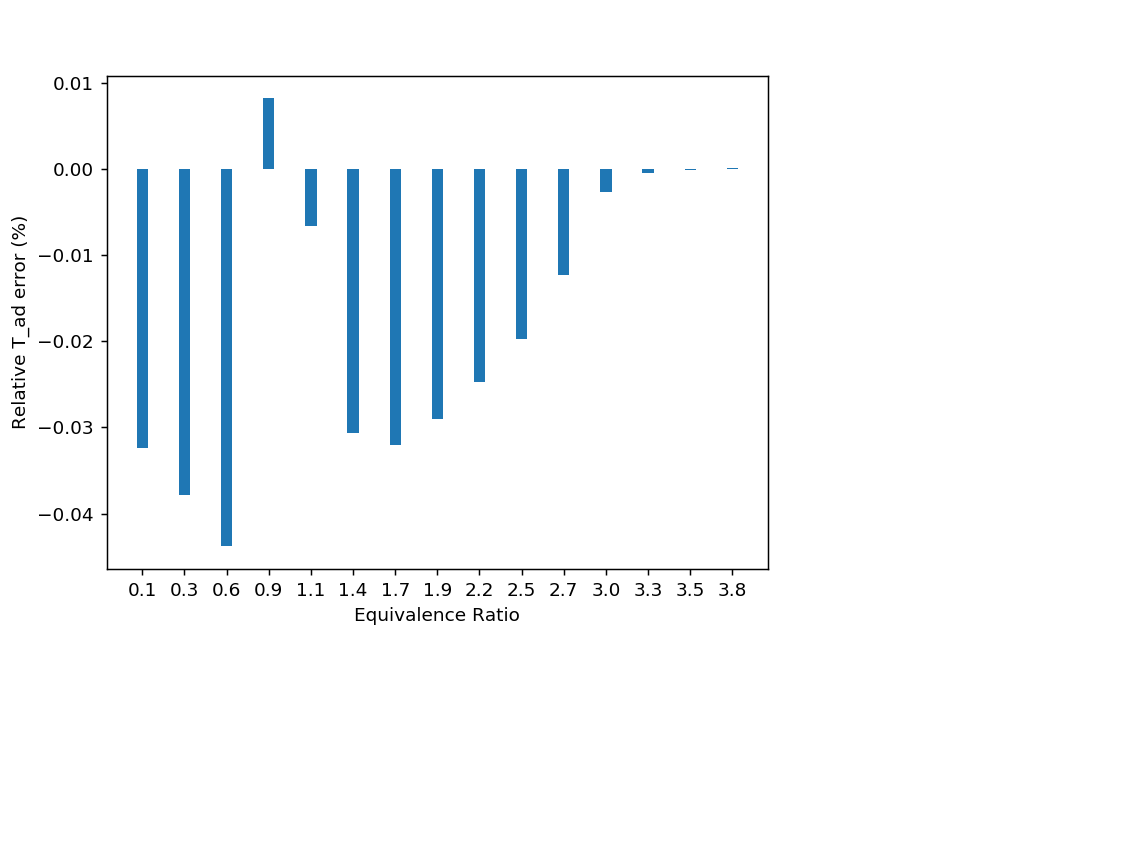

Text(0, 0.5, 'Relative T_ad error (%)')

In [85]:

fig, ax = plt.subplots()

plt.bar(f_a_ratios[::2].astype('|S3'),100*(T_ad_gri[::2] - T_ad_nuig[::2])/T_ad_nuig[::2], width=8./(npoints))
plt.xlabel('Equivalence Ratio')
plt.ylabel('Relative T_ad error (%)')

In [57]:
plt.show()